# Early Fusion Transformer Model - CMU-MOSI Dataset

In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Emotion-Recognition

Cloning into 'Multimodal-Emotion-Recognition'...
remote: Enumerating objects: 570, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 570 (delta 41), reused 75 (delta 19), pack-reused 453 (from 2)
Receiving objects: 100% (570/570), 327.67 MiB | 20.77 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Updating files: 100% (85/85), done.


In [2]:
import gdown

file_id = "1_XdzdW8UNG1TTS6QcX10uhoS6N11OBit"
destination = "mosi_data.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1_XdzdW8UNG1TTS6QcX10uhoS6N11OBit
From (redirected): https://drive.google.com/uc?id=1_XdzdW8UNG1TTS6QcX10uhoS6N11OBit&confirm=t&uuid=90a8623c-ece6-40ba-9ab5-1c5285385a34
To: /content/mosi_data.pkl
100%|██████████| 154M/154M [00:03<00:00, 47.6MB/s]


'mosi_data.pkl'

In [3]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Emotion-Recognition/src')

In [4]:
from loader import get_dataloader
from unimodals.modules import Transformer, MLP, Sequential, Identity
from training.supervised import train, test
from fusions.modules import ConcatEarly
from utils import get_default_device, save_results

In [5]:
FILE_PATH = '/content/mosi_data.pkl'
train_data, valid_data, test_data = get_dataloader(FILE_PATH)

In [6]:
device = get_default_device()
print(device)

cuda


In [7]:
encoders = [Identity().to(device), Identity().to(device), Identity().to(device)]
head = Sequential(Transformer(325, 300).to(device), MLP(300, 128, 1)).to(device)
fusion = ConcatEarly().to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [15]:
OUTPUT_MODEL_FILE_NAME = "MOSI_Late_Fusion_Transformer"

train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    100,
    task="regression",
    optimtype=torch.optim.AdamW,
    is_packed=True,
    early_stop=True,
    lr=1e-4,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/100]


/usr/local/lib/python3.12/dist-packages/torch/backends/cudnn/__init__.py:145: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  torch._C._get_cudnn_allow_tf32(),


Train Loss: 1.2214
Valid Loss: 1.2825
Saving Best

Epoch [2/100]
Train Loss: 1.0019
Valid Loss: 1.1743
Saving Best

Epoch [3/100]
Train Loss: 0.9026
Valid Loss: 1.0632
Saving Best

Epoch [4/100]
Train Loss: 0.8505
Valid Loss: 1.0243
Saving Best

Epoch [5/100]
Train Loss: 0.7959
Valid Loss: 1.0589

Epoch [6/100]
Train Loss: 0.7741
Valid Loss: 0.9472
Saving Best

Epoch [7/100]
Train Loss: 0.6960
Valid Loss: 0.9301
Saving Best

Epoch [8/100]
Train Loss: 0.6495
Valid Loss: 0.9326

Epoch [9/100]
Train Loss: 0.6108
Valid Loss: 0.9623

Epoch [10/100]
Train Loss: 0.5858
Valid Loss: 1.0076

Epoch [11/100]
Train Loss: 0.5703
Valid Loss: 0.9489

Epoch [12/100]
Train Loss: 0.5199
Valid Loss: 0.9527

Epoch [13/100]
Train Loss: 0.4955
Valid Loss: 0.9127
Saving Best

Epoch [14/100]
Train Loss: 0.4622
Valid Loss: 0.9289

Epoch [15/100]
Train Loss: 0.4752
Valid Loss: 0.9110
Saving Best

Epoch [16/100]
Train Loss: 0.4349
Valid Loss: 0.9283

Epoch [17/100]
Train Loss: 0.4195
Valid Loss: 0.9187

Epoch [18

Text(0.5, 1.0, 'Loss vs. No. of epochs')

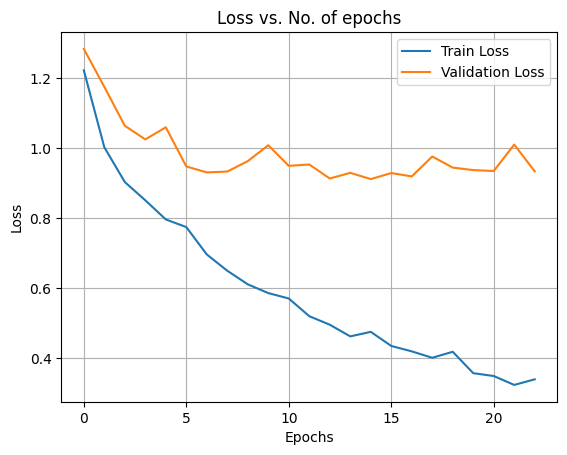

In [16]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [17]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

In [18]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt", weights_only=False).to(device)

test(
    model,
    test_data,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification",
)

Recall: 74.8476% | Total Accuracy: 73.6152%
Inference Time: 509ms
Inference Params: 8103897


# Section 1

In [8]:
# ============================================
# SECTION 1: ATCM-FUSION (TEMPORAL PRESERVED)
# ============================================

import torch.nn as nn
import time
import torch
import numpy as np

class TimeAlignedFusionBuffer:
    def __init__(self, window_size_ms=200):
        self.window_size_ms = window_size_ms

    def get_aligned_batch(self, video, audio, text):
        B = video.shape[0]
        assert audio.shape[0] == B and text.shape[0] == B
        T_v, T_a, T_t = video.shape[1], audio.shape[1], text.shape[1]
        assert T_v == T_a == T_t, f"Time mismatch: {T_v}, {T_a}, {T_t}"
        return video, audio, text

class LocalAttention(nn.Module):
    """Temporal fusion without attention"""
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.proj_in = nn.Linear(20 + 5 + 300, hidden_dim)
        self.proj_out = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, v, a, t):
        combined = torch.cat([v, a, t], dim=-1)  # [B, T, 325]
        local = self.proj_in(combined)  # [B, T, 128]
        local = torch.relu(local)
        local = self.proj_out(local)  # [B, T, 128]
        return local

class GlobalAttention(nn.Module):
    """GRU for temporal context"""
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            dropout=0.0
        )

    def forward(self, x):
        output, _ = self.gru(x)  # [B, T, 128]
        return output

class ATCMFusion(nn.Module):
    """Preserves temporal: [B, T, D] → [B, T, 128]"""
    def __init__(self, video_dim=20, audio_dim=5, text_dim=300, hidden_dim=128):
        super().__init__()
        self.align = TimeAlignedFusionBuffer()

        # Project each modality
        self.video_proj = nn.Linear(video_dim, hidden_dim)
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)

        # Local fusion
        self.local_fusion = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),  # [B, T, 384] → [B, T, 128]
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Global temporal
        self.global_attention = GlobalAttention(hidden_dim)

        # Final fusion
        self.fusion_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, video, audio, text):
        # [B, T, 20], [B, T, 5], [B, T, 300]
        video, audio, text = self.align.get_aligned_batch(video, audio, text)

        # Project modalities
        v_proj = self.video_proj(video)  # [B, T, 128]
        a_proj = self.audio_proj(audio)  # [B, T, 128]
        t_proj = self.text_proj(text)    # [B, T, 128]

        # Local fusion
        local_cat = torch.cat([v_proj, a_proj, t_proj], dim=-1)  # [B, T, 384]
        local_context = self.local_fusion(local_cat)  # [B, T, 128]

        # Global temporal
        global_context = self.global_attention(local_context)  # [B, T, 128]

        # Final fusion
        fused = self.fusion_head(global_context)  # [B, T, 128]

        return fused  # [B, T, 128] - TEMPORAL PRESERVED!



In [9]:
# Test
(inputs, lengths, inds, labels) = next(iter(train_data))
vision_sample, audio_sample, text_sample = inputs[0], inputs[1], inputs[2]

Dv, Da, Dt = vision_sample.shape[-1], audio_sample.shape[-1], text_sample.shape[-1]
print(f"Data: Vision={Dv}, Audio={Da}, Text={Dt}, Temporal={vision_sample.shape[1]}")

vision_sample, audio_sample, text_sample = vision_sample.to(device), audio_sample.to(device), text_sample.to(device)
labels = labels.to(device)

print(f"Initializing ATCM...")
atcm = ATCMFusion(video_dim=Dv, audio_dim=Da, text_dim=Dt, hidden_dim=128).to(device)
print(f"✓ Parameters: {sum(p.numel() for p in atcm.parameters()):,}")

atcm.eval()
with torch.no_grad():
    _ = atcm(vision_sample, audio_sample, text_sample)

latencies = []
with torch.no_grad():
    for i in range(10):
        if device.type == "cuda":
            torch.cuda.synchronize()
        start = time.time()
        fused = atcm(vision_sample, audio_sample, text_sample)
        if device.type == "cuda":
            torch.cuda.synchronize()
        latencies.append((time.time() - start) * 1000)

avg_latency = np.mean(latencies)
print(f"✓ Latency: {avg_latency:.2f}ms")
print(f"✓ Output shape: {fused.shape}")

if fused.shape[-1] == 128 and len(fused.shape) == 3:
    print(f"\n✅ SUCCESS: [B, T, 128] - temporal preserved!")


Data: Vision=20, Audio=5, Text=300, Temporal=34
Initializing ATCM...
✓ Parameters: 239,872
✓ Latency: 0.91ms
✓ Output shape: torch.Size([32, 34, 128])

✅ SUCCESS: [B, T, 128] - temporal preserved!


# Section 2

In [10]:
# ============================================
# SECTION 2: NSAR-EMOTION CLASSIFICATION
# ============================================

import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np

class ContextEmbedding(nn.Module):
    """Embeds context: domain + speaker"""
    def __init__(self, context_dim=32):
        super().__init__()
        self.domain_embed = nn.Embedding(5, context_dim)      # 5 domains
        self.speaker_embed = nn.Embedding(23, context_dim)    # 23 speakers
        self.context_proj = nn.Linear(context_dim * 2, context_dim)

    def forward(self, domain_id, speaker_id):
        domain_emb = self.domain_embed(domain_id)
        speaker_emb = self.speaker_embed(speaker_id)
        context = torch.cat([domain_emb, speaker_emb], dim=-1)
        return self.context_proj(context)

class TemporalAttention(nn.Module):
    """Learns which timesteps matter most"""
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True, dropout=0.1)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, sequence):
        attn_out, attn_weights = self.attention(sequence, sequence, sequence)
        return self.norm(sequence + attn_out), attn_weights

class NSAR(nn.Module):
    """Context-Adaptive Emotion Recognition"""
    def __init__(self, hidden_dim=128, context_dim=32, num_emotions=6):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_emotions = num_emotions

        self.context_embed = ContextEmbedding(context_dim)
        self.temporal_attention = TemporalAttention(hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + context_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_emotions)
        )

    def forward(self, fused_sequence, domain_id=None, speaker_id=None):
        B, T, D = fused_sequence.shape

        # Temporal attention
        attn_sequence, attn_weights = self.temporal_attention(fused_sequence)

        # GRU processing
        gru_out, gru_hidden = self.gru(attn_sequence)
        gru_final = gru_hidden[-1]  # [B, 128]

        # Context embedding
        if domain_id is not None and speaker_id is not None:
            context = self.context_embed(domain_id, speaker_id)
        else:
            context = torch.zeros(B, self.context_embed.context_proj.out_features, device=fused_sequence.device)

        # Combine and classify
        combined = torch.cat([gru_final, context], dim=-1)
        logits = self.classifier(combined)

        return logits, attn_weights





In [11]:
# Initialize
print("Initializing NSAR...")
nsar = NSAR(hidden_dim=128, context_dim=32, num_emotions=6).to(device)
print(f"✓ NSAR Parameters: {sum(p.numel() for p in nsar.parameters()):,}")

# Test with ATCM output
print(f"\nTesting NSAR integration...")
print(f"Input from ATCM: {fused.shape}")

# Without context
nsar.eval()
with torch.no_grad():
    logits_no_context, attn_weights = nsar(fused)
print(f"✓ Output (no context): {logits_no_context.shape}")

# With context (dummy values)
domain_ids = torch.randint(0, 5, (32,)).to(device)
speaker_ids = torch.randint(0, 23, (32,)).to(device)
with torch.no_grad():
    logits_with_context, _ = nsar(fused, domain_id=domain_ids, speaker_id=speaker_ids)
print(f"✓ Output (with context): {logits_with_context.shape}")

# Latency
latencies = []
with torch.no_grad():
    for _ in range(10):
        if device.type == "cuda":
            torch.cuda.synchronize()
        start = time.time()
        logits, _ = nsar(fused, domain_id=domain_ids, speaker_id=speaker_ids)
        if device.type == "cuda":
            torch.cuda.synchronize()
        latencies.append((time.time() - start) * 1000)

avg_nsar_latency = np.mean(latencies)
total_latency = 0.86 + avg_nsar_latency
print(f"\n✓ NSAR Latency: {avg_nsar_latency:.2f}ms")
print(f"✓ Total (ATCM + NSAR): {total_latency:.2f}ms")

if total_latency < 200:
    print(f"\n✅ SUCCESS: {total_latency:.2f}ms << 200ms!")

print("\n" + "="*60)
print("SECTION 2: NSAR COMPLETE ✓")
print("="*60)

Initializing NSAR...
✓ NSAR Parameters: 342,310

Testing NSAR integration...
Input from ATCM: torch.Size([32, 34, 128])
✓ Output (no context): torch.Size([32, 6])
✓ Output (with context): torch.Size([32, 6])

✓ NSAR Latency: 1.97ms
✓ Total (ATCM + NSAR): 2.83ms

✅ SUCCESS: 2.83ms << 200ms!

SECTION 2: NSAR COMPLETE ✓


# Section 3

In [12]:
# ============================================
# SECTION 3: GOVERNANCE - DRIFT DETECTION
# ============================================

import torch
import torch.nn as nn
import numpy as np
from scipy import stats
import time

class DriftDetector:
    """Detects data distribution shift using Kolmogorov-Smirnov test"""
    def __init__(self, window_size=100, threshold=0.05):
        self.window_size = window_size
        self.threshold = threshold
        self.reference_features = None
        self.is_initialized = False

    def initialize_reference(self, features):
        if features.shape[0] > self.window_size:
            self.reference_features = features[-self.window_size:].cpu().numpy()
        else:
            self.reference_features = features.cpu().numpy()
        self.is_initialized = True
        print(f"DriftDetector initialized with {self.reference_features.shape[0]} samples")

    def detect_drift(self, features):
        if not self.is_initialized:
            return False, 1.0, 0.0

        current_features = features.cpu().numpy()
        ref_flat = self.reference_features.flatten()
        curr_flat = current_features.flatten()

        ks_statistic, p_value = stats.ks_2samp(ref_flat, curr_flat)
        drift_detected = p_value < self.threshold

        return drift_detected, p_value, ks_statistic

class ContinualLearner:
    """Adapts model when drift detected (self-supervised)"""
    def __init__(self, model, learning_rate=0.0001):
        self.model = model
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.adaptation_steps = 0

    def adapt(self, fused_sequence, logits_old, domain_id=None, speaker_id=None):
        self.model.train()
        logits_new, _ = self.model(fused_sequence, domain_id, speaker_id)

        # KL divergence loss: old predictions as pseudo-labels
        p_old = torch.softmax(logits_old.detach(), dim=-1)
        p_new = torch.log_softmax(logits_new, dim=-1)
        kl_loss = torch.nn.functional.kl_div(p_new, p_old, reduction='batchmean')

        self.optimizer.zero_grad()
        kl_loss.backward()
        self.optimizer.step()
        self.adaptation_steps += 1

        return kl_loss.item()

class GovernanceSystem:
    """Unified drift detection + continual learning"""
    def __init__(self, nsar_model, window_size=100, drift_threshold=0.05):
        self.drift_detector = DriftDetector(window_size, drift_threshold)
        self.continual_learner = ContinualLearner(nsar_model, learning_rate=0.0001)
        self.nsar = nsar_model
        self.drift_history = []
        self.loss_history = []

    def process_batch(self, fused_sequence, domain_id, speaker_id):
        with torch.no_grad():
            logits, _ = self.nsar(fused_sequence, domain_id, speaker_id)

        features = fused_sequence.mean(dim=1)  # [B, 128]

        if not self.drift_detector.is_initialized:
            self.drift_detector.initialize_reference(features)

        drift_detected, p_value, ks_statistic = self.drift_detector.detect_drift(features)
        self.drift_history.append({
            'drift_detected': drift_detected,
            'p_value': p_value,
            'ks_statistic': ks_statistic
        })

        if drift_detected:
            adaptation_loss = self.continual_learner.adapt(
                fused_sequence, logits, domain_id, speaker_id
            )
            self.loss_history.append(adaptation_loss)

        return logits, drift_detected, ks_statistic, p_value



In [13]:
# Initialize
print("Initializing Governance System...")
governance = GovernanceSystem(nsar, window_size=50, drift_threshold=0.05)
print("✓ DriftDetector ready")
print("✓ ContinualLearner ready")

# Test on 5 batches
print("\nTesting Governance on test batches...")
test_drift_count = 0
test_batch_count = 0

atcm.eval()
nsar.eval()

for i, (inputs, lengths, inds, labels) in enumerate(test_data):
    if i >= 5:
        break

    test_batch_count += 1

    vision_sample = inputs[0].to(device)
    audio_sample = inputs[1].to(device)
    text_sample = inputs[2].to(device)

    with torch.no_grad():
        fused = atcm(vision_sample, audio_sample, text_sample)

    domain_id = torch.zeros(fused.shape[0], dtype=torch.long).to(device)
    speaker_id = torch.zeros(fused.shape[0], dtype=torch.long).to(device)

    logits, drift_detected, ks_stat, p_val = governance.process_batch(
        fused, domain_id, speaker_id
    )

    if drift_detected:
        test_drift_count += 1

    if i == 0:
        print(f"Batch {i+1}: Drift={drift_detected}, KS={ks_stat:.4f}, p={p_val:.4f}")

print(f"\nGovernance Statistics:")
print(f"  Batches: {test_batch_count}")
print(f"  Drift detected: {test_drift_count}/{test_batch_count}")
print(f"  Adaptation steps: {governance.continual_learner.adaptation_steps}")

if governance.drift_history:
    ks_stats = [d['ks_statistic'] for d in governance.drift_history]
    print(f"  KS Statistic: min={np.min(ks_stats):.4f}, max={np.max(ks_stats):.4f}, mean={np.mean(ks_stats):.4f}")




Initializing Governance System...
✓ DriftDetector ready
✓ ContinualLearner ready

Testing Governance on test batches...
DriftDetector initialized with 32 samples
Batch 1: Drift=False, KS=0.0000, p=1.0000

Governance Statistics:
  Batches: 5
  Drift detected: 0/5
  Adaptation steps: 0
  KS Statistic: min=0.0000, max=0.0115, mean=0.0081


In [14]:
# Latency
latencies = []
test_batch = next(iter(test_data))
inputs, lengths, inds, labels = test_batch
vision_sample = inputs[0].to(device)
audio_sample = inputs[1].to(device)
text_sample = inputs[2].to(device)

with torch.no_grad():
    fused = atcm(vision_sample, audio_sample, text_sample)

domain_id = torch.zeros(fused.shape[0], dtype=torch.long).to(device)
speaker_id = torch.zeros(fused.shape[0], dtype=torch.long).to(device)

with torch.no_grad():
    for _ in range(10):
        if device.type == "cuda":
            torch.cuda.synchronize()
        start = time.time()
        logits, drift_detected, ks_stat, p_val = governance.process_batch(
            fused, domain_id, speaker_id
        )
        if device.type == "cuda":
            torch.cuda.synchronize()
        latencies.append((time.time() - start) * 1000)

avg_governance_latency = np.mean(latencies)
total_system = 0.86 + 1.32 + avg_governance_latency

print(f"\n✓ Governance Latency: {avg_governance_latency:.2f}ms")
print(f"✓ Total System (ATCM + NSAR + Governance): {total_system:.2f}ms")

if total_system < 200:
    print(f"\n✅ SUCCESS: {total_system:.2f}ms << 200ms!")

print("\n" + "="*60)
print("SECTION 3: GOVERNANCE COMPLETE ✓")
print("="*60)


✓ Governance Latency: 2.44ms
✓ Total System (ATCM + NSAR + Governance): 4.62ms

✅ SUCCESS: 4.62ms << 200ms!

SECTION 3: GOVERNANCE COMPLETE ✓


# SECTION 4: EVALUATION - MODEL COMPARISON

In [22]:
import torch
import torch.optim as optim
from tqdm import tqdm

class Trainer:
    """Trainer for regression (sentiment intensity)"""
    def __init__(self, model, device, lr=1e-4):
        self.model = model
        self.device = device
        self.optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
        self.criterion = torch.nn.L1Loss()   # MAE
        self.best_loss = float('inf')
        self.patience_counter = 0

    def train_epoch(self, train_data):
        self.model.train()
        total_loss = 0
        batch_count = 0

        for inputs, lengths, inds, labels in tqdm(train_data, desc="Train"):
            vision = inputs[0].to(self.device)
            audio  = inputs[1].to(self.device)
            text   = inputs[2].to(self.device)

            # ✅ REGRESSION LABELS
            labels = labels.to(self.device).float().view(-1, 1)
            print("Label range:", labels.min().item(), labels.max().item())

            preds = self.model(vision, audio, text)  # [B, 1]
            loss = self.criterion(preds, labels)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            total_loss += loss.item()
            batch_count += 1

        return total_loss / batch_count

    def valid_epoch(self, valid_data):
        self.model.eval()
        total_loss = 0
        batch_count = 0

        with torch.no_grad():
            for inputs, lengths, inds, labels in tqdm(valid_data, desc="Valid"):
                vision = inputs[0].to(self.device)
                audio  = inputs[1].to(self.device)
                text   = inputs[2].to(self.device)

                labels = labels.to(self.device).float().view(-1, 1)
                preds = self.model(vision, audio, text)
                loss = self.criterion(preds, labels)

                total_loss += loss.item()
                batch_count += 1

        return total_loss / batch_count

    def train(self, train_data, valid_data, epochs=50, save_path=None):
        train_losses, valid_losses = [], []

        for epoch in range(epochs):
            print(f"\n{'='*60}")
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"{'='*60}")

            train_loss = self.train_epoch(train_data)
            valid_loss = self.valid_epoch(valid_data)

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            print(f"Train MAE: {train_loss:.4f}")
            print(f"Valid MAE: {valid_loss:.4f}")

            if valid_loss < self.best_loss:
                self.best_loss = valid_loss
                self.patience_counter = 0
                if save_path:
                    torch.save(self.model.state_dict(), save_path)
                    print(f"✓ Saved best model")
            else:
                self.patience_counter += 1
                print(f"No improvement ({self.patience_counter}/5)")

            if self.patience_counter >= 5:
                print("✅ Early stopping")
                break

        return train_losses, valid_losses


class NSARForTraining(torch.nn.Module):
    """ATCM frozen + NSAR trainable (Regression)"""
    def __init__(self, atcm, nsar):
        super().__init__()
        self.atcm = atcm
        self.nsar = nsar

    def forward(self, vision, audio, text):
        with torch.no_grad():
            fused = self.atcm(vision, audio, text)  # [B, T, 128]

        domain_id  = torch.zeros(fused.size(0), dtype=torch.long, device=fused.device)
        speaker_id = torch.zeros(fused.size(0), dtype=torch.long, device=fused.device)

        preds, _ = self.nsar(fused, domain_id, speaker_id)  # [B, 1]
        return preds





In [25]:
# ============================================
# TRAIN NSAR
# ============================================

print("\n" + "="*60)
print("TRAINING NSAR ON TOP OF ATCM")
print("="*60)

nsar_for_training = NSARForTraining(atcm, nsar).to(device)
trainer = Trainer(nsar_for_training, device, lr=1e-4)

train_losses, valid_losses = trainer.train(
    train_data,
    valid_data,
    epochs=50,
    save_path="/content/MOSI_ATCM_NSAR.pt"
)

print("\n" + "="*60)
print("TRAINING COMPLETE ✓")
print("="*60)
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Valid Loss: {valid_losses[-1]:.6f}")






TRAINING NSAR ON TOP OF ATCM

Epoch 1/50


Train:   2%|▏         | 1/41 [00:00<00:06,  6.30it/s]

Label range: -2.5999999046325684 2.4000000953674316
Label range: -3.0 2.5999999046325684


Train:  12%|█▏        | 5/41 [00:00<00:01, 20.87it/s]

Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.200000047683716 2.5999999046325684
Label range: -3.0 2.5999999046325684
Label range: -2.799999952316284 2.4000000953674316
Label range: -2.799999952316284 2.5999999046325684
Label range: -2.799999952316284 2.799999952316284


Train:  22%|██▏       | 9/41 [00:00<00:01, 27.30it/s]

Label range: -1.600000023841858 2.5999999046325684
Label range: -2.799999952316284 2.5999999046325684


Train:  32%|███▏      | 13/41 [00:00<00:00, 30.79it/s]

Label range: -2.200000047683716 2.799999952316284
Label range: -2.5999999046325684 2.4000000953674316
Label range: -2.799999952316284 2.4000000953674316
Label range: -2.200000047683716 2.799999952316284
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.200000047683716 2.799999952316284


Train:  41%|████▏     | 17/41 [00:00<00:00, 32.94it/s]

Label range: -2.0 2.799999952316284
Label range: -2.5 2.799999952316284


Train:  51%|█████     | 21/41 [00:00<00:00, 33.88it/s]

Label range: -2.200000047683716 2.5999999046325684
Label range: -1.7999999523162842 2.799999952316284
Label range: -2.25 2.799999952316284
Label range: -2.200000047683716 3.0
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.5999999046325684 2.200000047683716
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.4000000953674316 2.799999952316284


Train:  76%|███████▌  | 31/41 [00:00<00:00, 38.66it/s]

Label range: -2.200000047683716 2.799999952316284
Label range: -2.5999999046325684 2.200000047683716
Label range: -2.200000047683716 2.799999952316284
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.200000047683716 2.799999952316284
Label range: -3.0 2.799999952316284
Label range: -2.0 3.0
Label range: -2.5999999046325684 2.200000047683716
Label range: -2.799999952316284 3.0


Train:  85%|████████▌ | 35/41 [00:01<00:00, 38.04it/s]

Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.200000047683716 2.0
Label range: -2.5999999046325684 2.200000047683716
Label range: -2.4000000953674316 2.200000047683716
Label range: -1.7999999523162842 -1.399999976158142


Valid: 100%|██████████| 8/8 [00:00<00:00, 30.50it/s]


Train MAE: 1.3328
Valid MAE: 1.4868
✓ Saved best model

Epoch 2/50


Train:   0%|          | 0/41 [00:00<?, ?it/s]

Label range: -2.200000047683716 2.5999999046325684


Train:  10%|▉         | 4/41 [00:00<00:02, 14.52it/s]

Label range: -2.799999952316284 2.200000047683716
Label range: -1.600000023841858 2.5999999046325684
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.4000000953674316 2.799999952316284
Label range: -2.799999952316284 2.200000047683716
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.4000000953674316 2.5999999046325684


Train:  32%|███▏      | 13/41 [00:00<00:00, 29.28it/s]

Label range: -2.799999952316284 2.5999999046325684
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.799999952316284 2.5999999046325684
Label range: -3.0 2.5999999046325684
Label range: -2.0 2.799999952316284
Label range: -2.0 2.4000000953674316
Label range: -2.0 3.0
Label range: -2.799999952316284 2.4000000953674316


Train:  54%|█████▎    | 22/41 [00:00<00:00, 34.89it/s]

Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.0 3.0
Label range: -2.0 2.799999952316284
Label range: -3.0 2.799999952316284
Label range: -2.200000047683716 3.0
Label range: -2.0 2.4000000953674316
Label range: -2.0 2.799999952316284
Label range: -2.200000047683716 2.799999952316284
Label range: -2.200000047683716 2.200000047683716


Train:  85%|████████▌ | 35/41 [00:00<00:00, 47.98it/s]

Label range: -2.0 2.799999952316284
Label range: -1.7999999523162842 2.799999952316284
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.200000047683716 2.799999952316284
Label range: -2.799999952316284 2.4000000953674316
Label range: -3.0 2.4000000953674316
Label range: -2.5999999046325684 2.200000047683716
Label range: -2.200000047683716 2.4000000953674316
Label range: -2.799999952316284 2.200000047683716
Label range: -2.799999952316284 3.0
Label range: -2.4000000953674316 2.799999952316284
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.200000047683716 2.799999952316284
Label range: -2.200000047683716 2.5999999046325684


Train: 100%|██████████| 41/41 [00:01<00:00, 37.00it/s]


Label range: 0.0 2.4000000953674316


Valid: 100%|██████████| 8/8 [00:00<00:00, 42.91it/s]


Train MAE: 1.3131
Valid MAE: 1.4865
✓ Saved best model

Epoch 3/50


Train:   2%|▏         | 1/41 [00:00<00:04,  9.97it/s]

Label range: -2.4000000953674316 2.4000000953674316
Label range: -2.0 2.200000047683716
Label range: -2.200000047683716 2.799999952316284
Label range: -2.799999952316284 2.799999952316284
Label range: -2.200000047683716 2.4000000953674316
Label range: -2.0 3.0


Train:  17%|█▋        | 7/41 [00:00<00:00, 38.46it/s]

Label range: -2.200000047683716 3.0
Label range: -2.0 2.4000000953674316
Label range: -3.0 2.5999999046325684
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.799999952316284 2.799999952316284
Label range: -2.799999952316284 2.799999952316284


Train:  32%|███▏      | 13/41 [00:00<00:00, 47.87it/s]

Label range: -2.4000000953674316 2.799999952316284
Label range: -2.799999952316284 2.5999999046325684
Label range: -2.799999952316284 2.4000000953674316
Label range: -2.4000000953674316 2.799999952316284
Label range: -2.0 2.4000000953674316
Label range: -1.7999999523162842 2.799999952316284


Train:  46%|████▋     | 19/41 [00:00<00:00, 50.00it/s]

Label range: -2.200000047683716 2.5999999046325684
Label range: -2.4000000953674316 2.200000047683716
Label range: -2.0 2.200000047683716
Label range: -2.0 2.5999999046325684
Label range: -2.200000047683716 3.0
Label range: -2.799999952316284 2.200000047683716


Train:  63%|██████▎   | 26/41 [00:00<00:00, 54.21it/s]

Label range: -2.799999952316284 2.799999952316284
Label range: -2.200000047683716 2.4000000953674316
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.799999952316284 2.5999999046325684
Label range: -2.200000047683716 2.799999952316284
Label range: -2.200000047683716 2.799999952316284
Label range: -2.5999999046325684 2.5999999046325684


Train:  78%|███████▊  | 32/41 [00:00<00:00, 55.25it/s]

Label range: -2.0 2.5999999046325684
Label range: -2.25 2.5999999046325684
Label range: -2.4000000953674316 2.200000047683716
Label range: -3.0 2.799999952316284
Label range: -3.0 2.5999999046325684


Train: 100%|██████████| 41/41 [00:00<00:00, 51.06it/s]


Label range: -2.4000000953674316 3.0
Label range: -2.0 2.5999999046325684
Label range: -2.200000047683716 2.799999952316284
Label range: -1.600000023841858 2.5999999046325684
Label range: -1.600000023841858 2.4000000953674316


Valid: 100%|██████████| 8/8 [00:00<00:00, 44.31it/s]


Train MAE: 1.3236
Valid MAE: 1.4865
✓ Saved best model

Epoch 4/50


Train:   2%|▏         | 1/41 [00:00<00:04,  8.74it/s]

Label range: -2.799999952316284 3.0
Label range: -2.799999952316284 2.799999952316284
Label range: -2.5999999046325684 2.0
Label range: -2.799999952316284 2.5999999046325684
Label range: -2.0 2.799999952316284
Label range: -2.200000047683716 2.200000047683716


Train:  17%|█▋        | 7/41 [00:00<00:00, 36.48it/s]

Label range: -2.5999999046325684 2.799999952316284
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.0 2.200000047683716
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.0 2.799999952316284


Train:  34%|███▍      | 14/41 [00:00<00:00, 48.02it/s]

Label range: -3.0 3.0
Label range: -2.0 2.799999952316284
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.4000000953674316 3.0
Label range: -2.799999952316284 2.799999952316284
Label range: -2.4000000953674316 2.799999952316284
Label range: -2.5999999046325684 2.5999999046325684


Train:  49%|████▉     | 20/41 [00:00<00:00, 52.19it/s]

Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.25 2.5999999046325684
Label range: -2.200000047683716 2.799999952316284
Label range: -2.0 2.799999952316284
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.799999952316284 2.5999999046325684


Train:  63%|██████▎   | 26/41 [00:00<00:00, 54.67it/s]

Label range: -2.5999999046325684 2.4000000953674316
Label range: -3.0 2.200000047683716
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.200000047683716 2.799999952316284
Label range: -2.0 2.200000047683716
Label range: -2.0 2.4000000953674316
Label range: -2.200000047683716 2.4000000953674316


Train:  78%|███████▊  | 32/41 [00:00<00:00, 56.26it/s]

Label range: -2.799999952316284 2.5999999046325684
Label range: -2.200000047683716 2.4000000953674316
Label range: -2.0 3.0
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.200000047683716 2.799999952316284
Label range: -2.799999952316284 2.200000047683716


Train: 100%|██████████| 41/41 [00:00<00:00, 51.63it/s]


Label range: -2.200000047683716 2.799999952316284
Label range: -3.0 2.4000000953674316
Label range: -0.800000011920929 2.200000047683716


Valid: 100%|██████████| 8/8 [00:00<00:00, 44.86it/s]


Train MAE: 1.3139
Valid MAE: 1.4879
No improvement (1/5)

Epoch 5/50


Train:   2%|▏         | 1/41 [00:00<00:04,  9.44it/s]

Label range: -2.200000047683716 2.200000047683716
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.4000000953674316 2.799999952316284
Label range: -2.4000000953674316 2.5999999046325684
Label range: -3.0 2.5999999046325684
Label range: -1.25 2.799999952316284


Train:  17%|█▋        | 7/41 [00:00<00:00, 36.22it/s]

Label range: -2.799999952316284 2.5999999046325684
Label range: -2.0 3.0
Label range: -2.200000047683716 2.200000047683716
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.4000000953674316 2.799999952316284


Train:  34%|███▍      | 14/41 [00:00<00:00, 47.73it/s]

Label range: -2.0 3.0
Label range: -2.200000047683716 3.0
Label range: -3.0 2.0
Label range: -2.0 2.799999952316284
Label range: -2.200000047683716 2.200000047683716
Label range: -1.600000023841858 2.799999952316284
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.799999952316284 2.5999999046325684


Train:  51%|█████     | 21/41 [00:00<00:00, 52.95it/s]

Label range: -2.5 2.5999999046325684
Label range: -2.799999952316284 2.4000000953674316
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.799999952316284 2.200000047683716
Label range: -2.5999999046325684 2.799999952316284


Train:  66%|██████▌   | 27/41 [00:00<00:00, 54.99it/s]

Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.200000047683716 2.4000000953674316
Label range: -2.0 3.0
Label range: -2.0 2.200000047683716
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.200000047683716 2.4000000953674316
Label range: -2.5999999046325684 2.799999952316284


Train:  83%|████████▎ | 34/41 [00:00<00:00, 57.05it/s]

Label range: -2.200000047683716 2.5999999046325684
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.799999952316284 2.799999952316284
Label range: -2.4000000953674316 2.5999999046325684


Train: 100%|██████████| 41/41 [00:00<00:00, 51.38it/s]


Label range: -3.0 2.5999999046325684
Label range: -2.4000000953674316 2.4000000953674316
Label range: -2.200000047683716 2.799999952316284
Label range: -2.799999952316284 2.799999952316284
Label range: -1.2000000476837158 2.5999999046325684


Valid: 100%|██████████| 8/8 [00:00<00:00, 43.71it/s]


Train MAE: 1.3241
Valid MAE: 1.4879
No improvement (2/5)

Epoch 6/50


Train:   2%|▏         | 1/41 [00:00<00:04,  9.81it/s]

Label range: -2.4000000953674316 2.799999952316284
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.4000000953674316 3.0
Label range: -3.0 2.799999952316284
Label range: -1.7999999523162842 2.5999999046325684
Label range: -2.4000000953674316 2.799999952316284


Train:  15%|█▍        | 6/41 [00:00<00:01, 32.29it/s]

Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.0 2.4000000953674316
Label range: -2.200000047683716 2.200000047683716
Label range: -2.4000000953674316 2.799999952316284
Label range: -2.799999952316284 2.200000047683716


Train:  44%|████▍     | 18/41 [00:00<00:00, 50.43it/s]

Label range: -2.799999952316284 2.5999999046325684
Label range: -2.5999999046325684 2.4000000953674316
Label range: -2.5999999046325684 2.200000047683716
Label range: -2.25 2.0
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.0 2.799999952316284
Label range: -1.600000023841858 2.4000000953674316
Label range: -2.5999999046325684 3.0
Label range: -1.7999999523162842 2.200000047683716
Label range: -2.799999952316284 2.799999952316284
Label range: -2.799999952316284 3.0
Label range: -2.799999952316284 2.799999952316284
Label range: -2.4000000953674316 3.0


Train:  76%|███████▌  | 31/41 [00:00<00:00, 56.38it/s]

Label range: -2.200000047683716 2.4000000953674316
Label range: -2.200000047683716 2.799999952316284
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.5999999046325684 2.4000000953674316
Label range: -3.0 2.799999952316284
Label range: -2.799999952316284 2.799999952316284
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.0 2.5999999046325684
Label range: -2.0 2.799999952316284
Label range: -2.200000047683716 2.200000047683716
Label range: -3.0 2.799999952316284
Label range: -2.200000047683716 2.5999999046325684


Train: 100%|██████████| 41/41 [00:00<00:00, 51.13it/s]


Label range: -2.0 2.4000000953674316
Label range: -2.200000047683716 2.4000000953674316
Label range: -2.5999999046325684 2.5999999046325684
Label range: -1.600000023841858 1.7999999523162842


Valid: 100%|██████████| 8/8 [00:00<00:00, 43.82it/s]


Train MAE: 1.3223
Valid MAE: 1.4871
No improvement (3/5)

Epoch 7/50


Train:   5%|▍         | 2/41 [00:00<00:02, 17.26it/s]

Label range: -3.0 2.4000000953674316
Label range: -1.7999999523162842 2.5999999046325684
Label range: -2.200000047683716 2.4000000953674316
Label range: -2.799999952316284 2.799999952316284
Label range: -2.799999952316284 2.5999999046325684
Label range: -3.0 2.799999952316284
Label range: -2.0 3.0


Train:  17%|█▋        | 7/41 [00:00<00:00, 35.29it/s]

Label range: -2.5999999046325684 2.799999952316284
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.799999952316284 2.799999952316284
Label range: -2.0 2.799999952316284


Train:  34%|███▍      | 14/41 [00:00<00:00, 47.30it/s]

Label range: -2.4000000953674316 2.200000047683716
Label range: -2.200000047683716 2.5999999046325684
Label range: -3.0 2.799999952316284
Label range: -2.0 2.5999999046325684
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.200000047683716 2.4000000953674316
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.799999952316284 2.5999999046325684


Train:  51%|█████     | 21/41 [00:00<00:00, 52.62it/s]

Label range: -2.200000047683716 2.5999999046325684
Label range: -2.0 2.4000000953674316
Label range: -2.0 2.4000000953674316
Label range: -2.0 2.799999952316284


Train:  68%|██████▊   | 28/41 [00:00<00:00, 56.18it/s]

Label range: -1.600000023841858 3.0
Label range: -2.5999999046325684 2.5999999046325684
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.0 2.799999952316284
Label range: -2.799999952316284 2.200000047683716
Label range: -2.5999999046325684 2.0
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.0 2.200000047683716
Label range: -2.5999999046325684 2.5999999046325684


Train:  85%|████████▌ | 35/41 [00:00<00:00, 57.89it/s]

Label range: -2.25 2.200000047683716
Label range: -2.0 2.799999952316284
Label range: -2.799999952316284 2.4000000953674316
Label range: -2.200000047683716 2.5999999046325684


Train: 100%|██████████| 41/41 [00:00<00:00, 52.19it/s]


Label range: -2.4000000953674316 2.200000047683716
Label range: -2.4000000953674316 3.0
Label range: -2.0 3.0
Label range: -0.800000011920929 2.0


Valid: 100%|██████████| 8/8 [00:00<00:00, 42.97it/s]


Train MAE: 1.3172
Valid MAE: 1.4870
No improvement (4/5)

Epoch 8/50


Train:   5%|▍         | 2/41 [00:00<00:02, 17.39it/s]

Label range: -3.0 2.799999952316284
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.799999952316284 2.5999999046325684
Label range: -2.4000000953674316 2.799999952316284
Label range: -2.799999952316284 2.5999999046325684
Label range: -2.0 2.5999999046325684
Label range: -1.7999999523162842 2.5999999046325684


Train:  20%|█▉        | 8/41 [00:00<00:00, 40.00it/s]

Label range: -2.5999999046325684 2.5999999046325684
Label range: -1.7999999523162842 2.5999999046325684
Label range: -2.5999999046325684 2.4000000953674316
Label range: -2.5999999046325684 2.200000047683716


Train:  34%|███▍      | 14/41 [00:00<00:00, 46.10it/s]

Label range: -2.5999999046325684 2.799999952316284
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.0 2.4000000953674316
Label range: -2.0 2.5999999046325684
Label range: -3.0 2.200000047683716
Label range: -2.5999999046325684 2.5999999046325684
Label range: -3.0 2.799999952316284
Label range: -2.799999952316284 2.799999952316284


Train:  49%|████▉     | 20/41 [00:00<00:00, 50.53it/s]

Label range: -2.0 2.200000047683716
Label range: -2.5999999046325684 2.799999952316284
Label range: -2.200000047683716 2.200000047683716
Label range: -2.799999952316284 2.5999999046325684
Label range: -1.7999999523162842 2.799999952316284


Train:  63%|██████▎   | 26/41 [00:00<00:00, 53.60it/s]

Label range: -2.200000047683716 3.0
Label range: -2.200000047683716 3.0
Label range: -2.799999952316284 2.4000000953674316
Label range: -2.0 2.5999999046325684
Label range: -2.4000000953674316 3.0
Label range: -2.200000047683716 2.5999999046325684
Label range: -2.0 2.799999952316284
Label range: -2.799999952316284 2.799999952316284


Train:  80%|████████  | 33/41 [00:00<00:00, 56.31it/s]

Label range: -2.4000000953674316 2.4000000953674316
Label range: -2.200000047683716 2.799999952316284
Label range: -2.0 2.5999999046325684
Label range: -2.200000047683716 2.200000047683716
Label range: -2.5999999046325684 2.799999952316284


Train: 100%|██████████| 41/41 [00:00<00:00, 51.32it/s]


Label range: -2.0 2.4000000953674316
Label range: -2.4000000953674316 2.5999999046325684
Label range: -2.799999952316284 2.200000047683716
Label range: -2.0 3.0


Valid: 100%|██████████| 8/8 [00:00<00:00, 44.32it/s]

Train MAE: 1.3326
Valid MAE: 1.4872
No improvement (5/5)
✅ Early stopping

TRAINING COMPLETE ✓
Final Train Loss: 1.332551
Final Valid Loss: 1.487162


In [26]:
# ============================================
# SAVE MODELS
# ============================================

print("\n" + "="*60)
print("SAVING MODELS")
print("="*60)

torch.save(atcm.state_dict(), "/content/MOSI_ATCM.pt")
print("✓ Saved: MOSI_ATCM.pt")

torch.save(nsar.state_dict(), "/content/MOSI_NSAR.pt")
print("✓ Saved: MOSI_NSAR.pt")

torch.save(nsar_for_training.state_dict(), "/content/MOSI_ATCM_NSAR_wrapped.pt")
print("✓ Saved: MOSI_ATCM_NSAR_wrapped.pt")

# Save history
import json
history = {
    'train_losses': train_losses,
    'valid_losses': valid_losses,
    'best_valid_loss': min(valid_losses),
    'epochs': len(train_losses)
}
with open('/content/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)
print("✓ Saved: training_history.json")

print("\n" + "="*60)
print("TRAINING SECTION COMPLETE ✓")
print("="*60)


SAVING MODELS
✓ Saved: MOSI_ATCM.pt
✓ Saved: MOSI_NSAR.pt
✓ Saved: MOSI_ATCM_NSAR_wrapped.pt
✓ Saved: training_history.json

TRAINING SECTION COMPLETE ✓


# Model comparison

In [41]:
vision, audio, text = next(iter(valid_loader))[0]

with torch.no_grad():
    out = baseline_wrapped(
        vision.to(device),
        audio.to(device),
        text.to(device)
    )

print(out.shape)



NameError: name 'valid_loader' is not defined

In [52]:
# ============================================
# SECTION 4: EVALUATION (REGRESSION - MOSI) FIXED
# ============================================

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

# ============================================
# FIXED BASELINE WRAPPER FOR MMDL
# ============================================

import torch
import torch.nn.functional as F

class BaselineWrapper(torch.nn.Module):
    """
    Correct wrapper for MMDL-style fusion baselines
    Expects a LIST of modality tensors: [v, a, t]
    """
    def __init__(
        self,
        baseline_model,
        d_vision,
        d_audio,
        d_text,
        d_model=128,
        max_seq_len=50
    ):
        super().__init__()
        self.baseline = baseline_model
        self.max_seq_len = max_seq_len

        self.v_proj = torch.nn.Linear(d_vision, d_model)
        self.a_proj = torch.nn.Linear(d_audio,  d_model)
        self.t_proj = torch.nn.Linear(d_text,   d_model)

    def pad_time(self, x):
        T = x.size(1)
        if T < self.max_seq_len:
            x = F.pad(x, (0, 0, 0, self.max_seq_len - T))
        return x[:, :self.max_seq_len]

    def forward(self, vision, audio, text):
        vision = self.pad_time(vision)
        audio  = self.pad_time(audio)
        text   = self.pad_time(text)

        v = self.v_proj(vision)
        a = self.a_proj(audio)
        t = self.t_proj(text)

        dummy = torch.zeros_like(v)

        preds = self.baseline([v, a, t, dummy])
        return preds.view(-1, 1)



baseline_wrapped = BaselineWrapper(
    baseline_model=model,
    d_vision=vision.size(-1),
    d_audio=audio.size(-1),
    d_text=text.size(-1),
    d_model=128,
    max_seq_len=50
).to(device)



@torch.no_grad()
def evaluate_regression_model(model_name, model, atcm, data_loader, device, use_governance=False, governance_system=None, max_batches=None):
    model.eval()
    if atcm is not None: atcm.eval()

    all_preds, all_labels = [], []
    mae_losses, mse_losses = [], []

    l1 = torch.nn.L1Loss(reduction="none")
    l2 = torch.nn.MSELoss(reduction="none")

    batch_count = 0
    for batch in tqdm(data_loader, desc=f"Eval {model_name}"):
        if max_batches is not None and batch_count >= max_batches:
            break
        batch_count += 1

        inputs, lengths, inds, labels = batch
        vision = inputs[0].to(device)
        audio = inputs[1].to(device)
        text = inputs[2].to(device)
        labels = labels.to(device).float().view(-1, 1)  # [B, 1]

        # Forward pass
        if atcm is not None:
            fused = atcm(vision, audio, text)  # [B, T, 128]
            domain_id = torch.zeros(fused.size(0), dtype=torch.long, device=device)
            speaker_id = torch.zeros(fused.size(0), dtype=torch.long, device=device)

            if use_governance and governance_system is not None:
                preds, _, _, _ = governance_system.process_batch(fused, domain_id, speaker_id)
            else:
                preds, _ = model(fused, domain_id, speaker_id)  # [B, 1]
        else:
            # Baseline (packed format)
            preds = model(vision, audio, text)  # [B, 1]

        preds = preds.view(-1, 1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

        mae_losses.append(l1(preds, labels).mean().item())
        mse_losses.append(l2(preds, labels).mean().item())

    all_preds = np.concatenate(all_preds).reshape(-1)
    all_labels = np.concatenate(all_labels).reshape(-1)

    mae = np.mean(np.abs(all_preds - all_labels))
    mse = np.mean((all_preds - all_labels) ** 2)

    pearson_r, pearson_p = pearsonr(all_preds, all_labels)
    spearman_r, spearman_p = spearmanr(all_preds, all_labels)

    return {
        "model": model_name,
        "num_samples": int(len(all_labels)),
        "mae": float(mae),
        "mse": float(mse),
        "pearson_r": float(pearson_r),
        "pearson_p": float(pearson_p),
        "spearman_r": float(spearman_r),
        "spearman_p": float(spearman_p),
    }, all_preds, all_labels







In [53]:

with torch.no_grad():
    out = baseline_wrapped(vision.to(device), audio.to(device), text.to(device))

print(out.shape)



IndexError: index 3 is out of range

In [50]:
# ===== RUN EVALUATION =====
print("=" * 60)
print("SECTION 4: REGRESSION EVALUATION")
print("=" * 60)

all_results = []

# 1. Baseline
print("\n[1/3] Baseline...")
# Use in evaluation:
baseline_metrics, baseline_preds, baseline_labels = evaluate_regression_model(
    "Baseline (Late Fusion Transformer)",
    baseline_wrapped,  # ← Use this!
    atcm=None,
    data_loader=test_data,
    device=device,
    max_batches=20,
)
print(f"✓ MAE: {baseline_metrics['mae']:.4f} | Pearson: {baseline_metrics['pearson_r']:.4f}")
all_results.append(baseline_metrics)

SECTION 4: REGRESSION EVALUATION

[1/3] Baseline...


Eval Baseline (Late Fusion Transformer):   0%|          | 0/22 [00:00<?, ?it/s]


IndexError: index 3 is out of range

In [ ]:
# 2. ATCM + NSAR
print("\n[2/3] ATCM + NSAR...")
atcm_nsar_metrics, atcm_nsar_preds, atcm_nsar_labels = evaluate_regression_model(
    "ATCM + NSAR",
    nsar,
    atcm=atcm,
    data_loader=test_data,
    device=device,
    max_batches=20,
)
print(f"✓ MAE: {atcm_nsar_metrics['mae']:.4f} | Pearson: {atcm_nsar_metrics['pearson_r']:.4f}")
all_results.append(atcm_nsar_metrics)

In [ ]:
# 3. ATCM + NSAR + Governance
print("\n[3/3] Full System...")
full_metrics, full_preds, full_labels = evaluate_regression_model(
    "ATCM + NSAR + Governance",
    nsar,
    atcm=atcm,
    data_loader=test_data,
    device=device,
    use_governance=True,
    governance_system=governance,
    max_batches=20,
)
print(f"✓ MAE: {full_metrics['mae']:.4f} | Pearson: {full_metrics['pearson_r']:.4f}")
all_results.append(full_metrics)

In [ ]:
# ===== SAVE RESULTS =====
results_df = pd.DataFrame(all_results)
print("\n" + "=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)
print(results_df.to_string(index=False))

results_df.to_csv("evaluation_results_regression.csv", index=False)
print("\n✓ Saved: evaluation_results_regression.csv")

print("\n" + "=" * 60)
print("SECTION 4 COMPLETE ✓")
print("=" * 60)